In [1]:
import torch
import cv2
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from pycocotools.coco import COCO
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


#from utilities.calibration import DatasetLoader, CalibrationRunner, CalibrationMetrics
from utilities.calibration import generate_calibration
from utilities.visualization import visualize_conformal_predictions, visualize_with_ground_truth
from cppredictor import build_conformal_predictor
#from cppredictor import coco_label_from_index

In [2]:
#!touch /home/RCNN/detectron2/utilities/__init__.py

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [4]:
# Config model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.DEVICE = 'cuda'

# Build predictor
predictor = build_conformal_predictor(cfg)

In [5]:
# Generate calibration
val_img_path = "/home/datasets/coco/val2017/"
val_json_file = "/home/datasets/coco/annotations/instances_val2017.json"
cal_json_file = "calib_98.json"


In [6]:
'''
# bonferroni calibration : 4 multiple testing. target alpha = 0.05, alpha for each dim(x1,y1,x2,y2) = 0.05/4 = 0.0125
classwise_qhat, global_qhat = generate_calibration(
    image_root=val_img_path,
    json_file=val_json_file,
    predictor=predictor,
    alpha=0.02,  # 98% 신뢰도
    output_file=cal_json_file,
    save_agg=True
)

print(f"Global confidence threshold: {1 - global_qhat:.4f}")
print(f"Number of classes with calibration: {len(classwise_qhat)}")
'''

'\n# bonferroni calibration : 4 multiple testing. target alpha = 0.05, alpha for each dim(x1,y1,x2,y2) = 0.05/4 = 0.0125\nclasswise_qhat, global_qhat = generate_calibration(\n    image_root=val_img_path,\n    json_file=val_json_file,\n    predictor=predictor,\n    alpha=0.02,  # 98% 신뢰도\n    output_file=cal_json_file,\n    save_agg=True\n)\n\nprint(f"Global confidence threshold: {1 - global_qhat:.4f}")\nprint(f"Number of classes with calibration: {len(classwise_qhat)}")\n'

In [7]:
'''
def visualize_conformal_predictions(image, outputs, cfg, scale=1.0):
    """
    이미지와 모델 출력 결과에서 Conformal Region을 시각화하는 함수.
    
    Args:
        image (np.ndarray): 원본 이미지 (BGR 포맷)
        outputs (dict): 모델 예측 결과 (instances 포함)
        cfg: detectron2 설정 객체
        scale (float): visualizer scaling factor (default: 1.0)
    
    Returns:
        output_img (np.ndarray): Conformal Region Box가 그려진 이미지
    """

    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=scale)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    output_img = out.get_image()[:, :, ::-1].copy()
    conformal_regions = outputs["instances"].conformal_region
    for region in conformal_regions:
        #outer box
        pt1 = (int(region["x1_min"]), int(region["y1_min"]))
        pt2 = (int(region["x2_max"]), int(region["y2_max"]))
        cv2.rectangle(output_img, pt1, pt2, (0, 255, 0), 1)
        #inner box
        pt3 = (int(region["x1_max"]), int(region["y1_min"]))
        pt4 = (int(region["x2_min"]), int(region["y2_max"]))
        cv2.rectangle(output_img, pt3, pt4, (0, 255, 0), 1)
    return output_img
'''

'\ndef visualize_conformal_predictions(image, outputs, cfg, scale=1.0):\n    """\n    이미지와 모델 출력 결과에서 Conformal Region을 시각화하는 함수.\n    \n    Args:\n        image (np.ndarray): 원본 이미지 (BGR 포맷)\n        outputs (dict): 모델 예측 결과 (instances 포함)\n        cfg: detectron2 설정 객체\n        scale (float): visualizer scaling factor (default: 1.0)\n    \n    Returns:\n        output_img (np.ndarray): Conformal Region Box가 그려진 이미지\n    """\n\n    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=scale)\n    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))\n    output_img = out.get_image()[:, :, ::-1].copy()\n    conformal_regions = outputs["instances"].conformal_region\n    for region in conformal_regions:\n        #outer box\n        pt1 = (int(region["x1_min"]), int(region["y1_min"]))\n        pt2 = (int(region["x2_max"]), int(region["y2_max"]))\n        cv2.rectangle(output_img, pt1, pt2, (0, 255, 0), 1)\n        #inner box\n        pt3 = (int(re

In [8]:
test_img_path = "/home/datasets/coco/val2017/000000000872.jpg"
test_json_file = "/home/datasets/coco/annotations/instances_val2017.json"

# option : draw Ground truth box
coco = COCO(test_json_file)
img_id = int(os.path.basename(test_img_path).split('.')[0])
ann_ids = coco.getAnnIds(imgIds=img_id)
annotations = coco.loadAnns(ann_ids)
image = cv2.imread(test_img_path)

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


/opt/anaconda3/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loaded calibration data
outtebox : tensor(114.0232, device='cuda:0') tensor(75.4974, device='cuda:0') tensor(438.8538, device='cuda:0') tensor(671.5616, device='cuda:0')
innerbox : tensor(208.4766, device='cuda:0') tensor(167.6402, device='cuda:0') tensor(336.5667, device='cuda:0') tensor(529.8210, device='cuda:0')
outtebox : tensor(220.9152, device='cuda:0') tensor(54.6819, device='cuda:0') tensor(485.2761, device='cuda:0') tensor(617.5850, device='cuda:0')
innerbox : tensor(315.3686, device='cuda:0') tensor(146.8248, device='cuda:0') tensor(382.9890, device='cuda:0') tensor(475.8444, device='cuda:0')
outtebox : tensor(400.4547, device='cuda:0') tensor(167.3620, device='cuda:0') tensor(432.2166, device='cuda:0') tensor(196.7291, device='cuda:0')
innerbox : tensor(411.3201, device='cuda:0') tensor(174.3599, device='cuda:0') tensor(425.3213, device='cuda:0') tensor(183.7225, device='cuda:0')


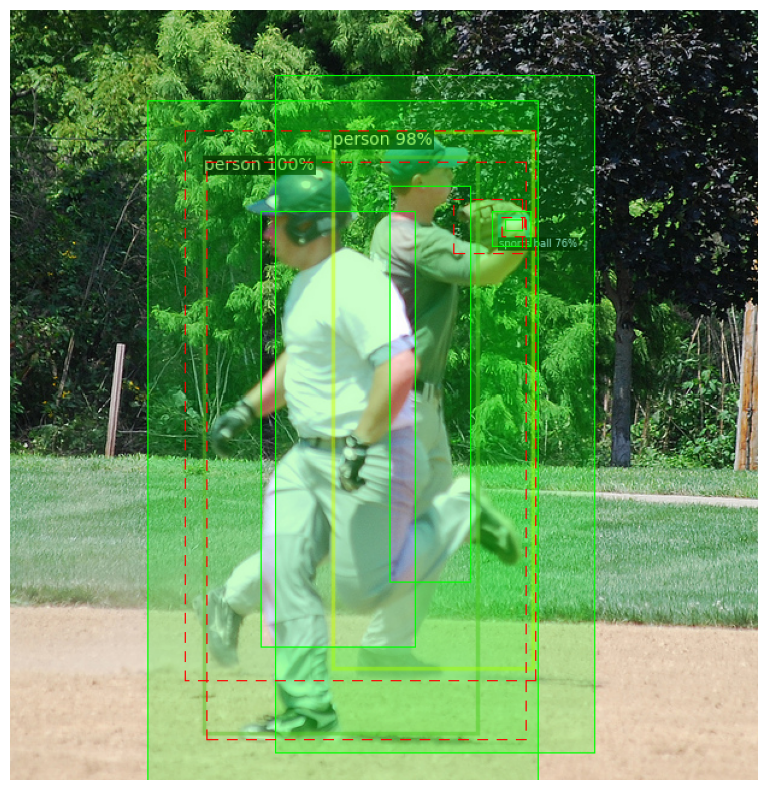

In [9]:
# Predict and conformalize
outputs = predictor(image)
predictor.conformalize(outputs["instances"], calib_path=cal_json_file)

# Visualize the conformal predictions
output_img = visualize_conformal_predictions(image, outputs, cfg)
# 또는 Ground Truth와 함께 시각화
output_img_with_gt = visualize_with_ground_truth(image, outputs, cfg, annotations)


# 결과 표시
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(output_img_with_gt, cv2.COLOR_BGR2RGB))
#plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.tight_layout()
plt.show()